# Stock Price Forecasting with Machine Learning

Paper replication code

# 0. Preliminary workings

### 0.1 Uploading necessary packages

Here we import all the packages that this paper requires. If there's something missing, one can download packages just by simply running a command: "!pip install name-of-the-package", but without brackets

In [4]:
import os
import numpy as np
from scipy.stats import norm, t, uniform
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from tqdm import tqdm
from datetime import datetime as dt

from linearmodels.panel import PanelOLS
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import HuberRegressor
from sklearn.cross_decomposition import PLSRegression
import time
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
from scipy.optimize import minimize
from functools import partial
from numpy.linalg import svd
from sklearn.linear_model import ElasticNet
from group_lasso import GroupLasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization
from keras.regularizers import L1L2
from keras.optimizers import Adam

import seaborn as sns

warnings.filterwarnings("ignore")
random.seed(123)

### 0.2.2. New set of functions

Here we initialize all the necessary functions for the models used in the paper, as well as the evaluation methods. 

In [6]:
# huber loss function for customized objective function

# gradient of huber loss with respect to y_pred
def grad_huber_obj(y_true, y_pred):
    xi = 1.35 
    # Though I do not want to make it hard-coded, lightgbm, behind the scene, evaluates the # of parameters
    # of the objective function first, then pass according # of parameters. I tried to use partial to set 
    # the value of xi. It did not work.
    # I refer the readers to the source code to have a better understanding of the issue:
    # (https://github.com/microsoft/LightGBM/blob/master/python-package/lightgbm/sklearn.py)
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    N = len(y_true)
    resid = y_true - y_pred
    ind_m = np.where(np.abs(resid)<=xi)
    ind_u = np.where(resid>xi)
    ind_l = np.where(resid< -xi)
    grad = np.zeros(N)
    try:
        grad[ind_m] = (-2*(y_true-y_pred))[ind_m]
    except:
        pass
    try:
        grad[ind_u] = np.repeat(2*xi,N)[ind_u]
    except:
        pass
    try:
        grad[ind_l] = np.repeat(-2*xi,N)[ind_l]
    except:
        pass
    return grad/N

# hessian of huber loss with respect to y_pred
def hess_huber_obj(y_true, y_pred):
    xi = 1.35
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()
    N = len(y_true)
    resid = y_true - y_pred
    ind_m = np.where(np.abs(resid)<=xi)
    ind_u = np.where(resid>xi)
    ind_l = np.where(resid< -xi)
    hess = np.zeros(N)
    try:
        hess[ind_m] = np.repeat(2,N)[ind_m]
    except:
        pass
    return hess/N

# huber loss for lgbm
def huber_obj(y_true, y_pred):
    grad = grad_huber_obj(y_true, y_pred)
    hess = hess_huber_obj(y_true, y_pred)
    return grad, hess

In [7]:
# Loss Function

# Scoring Function
# out-of-sample R squared
def R_oos(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted).flatten()
    predicted = np.where(predicted<0,0,predicted)
    return 1 - (np.dot((actual-predicted),(actual-predicted)))/(np.dot(actual,actual))

# Validation Function
def val_fun(model, params: dict, X_trn, y_trn, X_vld, y_vld, illustration=True, sleep=0, is_NN=False):
    best_ros = None
    lst_params = list(ParameterGrid(params))
    for param in lst_params:
        if best_ros == None:
            if is_NN:
                mod = model().set_params(**param).fit(X_trn, y_trn, X_vld, y_vld)
            else:
                mod = model().set_params(**param).fit(X_trn, y_trn)
            best_mod = mod
            y_pred = mod.predict(X_vld)
            best_ros = R_oos(y_vld, y_pred)
            best_param = param
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample R squared on validation set: {best_ros*100:.5f}%')
                print('*'*60)
        else:
            #time.sleep(sleep)
            if is_NN:
                mod = model().set_params(**param).fit(X_trn, y_trn, X_vld, y_vld)
            else:
                mod = model().set_params(**param).fit(X_trn, y_trn)
            y_pred = mod.predict(X_vld)
            ros = R_oos(y_vld, y_pred)
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample R squared on validation set: {ros*100:.5f}%')
                print('*'*60)
            if ros > best_ros:
                best_ros = ros
                best_mod = mod
                best_param = param
    if illustration:
        print('\n'+'#'*60)
        print('Tuning process finished!!!')
        print(f'The best setting is: {best_param}')
        print(f'with R2oos {best_ros*100:.2f}% on validation set.')
        print('#'*60)
    return best_mod
    

# Pairwise Comparison
# Diebold-Mariano test statistics

# Evaluation Output
def evaluate(actual, predicted, insample=False):
    if insample:
        print('*'*15+'In-Sample Metrics'+'*'*15)
        print(f'The in-sample R2 is {r2_score(actual,predicted)*100:.2f}%')
        print(f'The in-sample MSE is {mean_squared_error(actual,predicted):.3f}')
    else:
        print('*'*15+'Out-of-Sample Metrics'+'*'*15)
        print(f'The out-of-sample R2 is {R_oos(actual,predicted)*100:.2f}%')
        print(f'The out-of-sample MSE is {mean_squared_error(actual,predicted):.3f}')

In [8]:
class PCRegressor:
    def __init__(self,n_PCs=1,loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber','mse']:
            raise AttributeError(
            f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
        
    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self
        
    def fit(self,X,y):
        X = np.array(X)
        N,K = X.shape
        y = np.array(y_trn).reshape((N,1))
        self.mu = np.mean(X,axis=0).reshape((1,K))
        self.sigma = np.std(X,axis=0).reshape((1,K))
        self.sigma = np.where(self.sigma==0,1,self.sigma)
        X = (X-self.mu)/self.sigma
        pca = PCA()
        X = pca.fit_transform(X)[:,:self.n_PCs]
        self.pc_coef = pca.components_.T[:,:self.n_PCs]
        if self.loss == 'mse':
            self.model = LinearRegression().fit(X,y)
        else:
            self.model = HuberRegressor().fit(X,y)
        return self
    
    def predict(self,X):
        X = np.array(X)
        X = (X-self.mu)/self.sigma
        X = X @ self.pc_coef
        return self.model.predict(X)
    
    def get_params(self, X,y):
        X = np.array(X)
        N,K = X.shape
        y = np.array(y_trn).reshape((N,1))
        self.mu = np.mean(X,axis=0).reshape((1,K))
        self.sigma = np.std(X,axis=0).reshape((1,K))
        self.sigma = np.where(self.sigma==0,1,self.sigma)
        X = (X-self.mu)/self.sigma
        pca = PCA()
        X = pca.fit_transform(X)[:,:self.n_PCs]
        self.pc_coef = pca.components_.T[:,:self.n_PCs]
        return self.pc_coef

In [9]:
# mse
def mse(actual, predicted):
    actual, predicted = np.array(actual).flatten(), np.array(predicted).flatten()
    resid = actual - predicted
    return np.mean(resid**2)

# huber objective function
def huber(actual, predicted, xi):
    actual, predicted = np.array(actual).flatten(), np.array(predicted).flatten()
    resid = actual - predicted
    huber_loss = np.where(np.abs(resid)<=xi, diff**2, 2*xi*np.abs(resid)-xi**2)
    return np.mean(huber_loss)

# proximal operator
def prox(theta,lmd,rho,gamma):
    return (1/(1+lmd*gamma*rho))*softhred(theta,(1-rho)*gamma*lmd)

# soft-thresholding operator
def softhred(x,mu):
    x = np.where(np.abs(x)<=mu, 0, x)
    x = np.where((np.abs(x)>mu) & (x>0), x-mu, x)
    x = np.where((np.abs(x)>mu) & (x<0), x+mu, x)
    return x

# penalized mse
def mse_pnl(theta, X, y, lmd, rho):
    K = X.shape[1]
    X = np.array(X)
    N = len(y)
    y = np.array(y).reshape((N,1))
    resid = y - X@theta.reshape((K,1))
    return np.mean(resid**2) + lmd*(1-rho)*np.sum(np.abs(theta)) + 0.5*lmd*rho*np.sum(theta**2)

# penalized huber objective function
def huber_pnl(theta, X, y, xi, lmd, rho):
    K = X.shape[1]
    X = np.array(X)
    N = len(y)
    y = np.array(y).reshape((N,1))
    resid = y - X@theta.reshape((K,1))
    huber_loss = np.where(np.abs(resid)<=xi, resid**2, 2*xi*np.abs(resid)-xi**2)
    return np.mean(huber_loss) + lmd*(1-rho)*np.sum(np.abs(theta)) + 0.5*lmd*rho*np.sum(theta**2)

# gradient of mse
def grad_mse(theta, X, y, lmd, rho):
    K = X.shape[1]
    X = np.array(X)
    N = len(y)
    y = np.array(y).reshape((N,1))
    theta = np.array(theta).reshape((K,1))
    grad = (X.T @ (y - X@theta))/N + lmd*(1-rho)*np.where(theta>0,1,-1) + lmd*rho*theta
    return grad.flatten()

# gradient of huber loss
def grad_huber(theta, X, y, xi, lmd, rho):
    K = X.shape[1]
    X = np.array(X)
    N = len(y)
    y = np.array(y).reshape((N,1))
    theta = np.array(theta).reshape((K,1))
    resid = y - X@theta
    ind_m = np.where(np.abs(resid)<=xi)
    ind_u = np.where(resid>xi)
    ind_l = np.where(resid< -xi)
    try:
        grad_m = X[ind_m].T @ (y[ind_m] - X[ind_m]@theta)
    except:
        grad_m = np.zeros((K,1))
    try:
        grad_u = 2*xi* X[ind_u].T@np.ones((len(ind_u[0]),1))
    except:
        grad_u = np.zeros((K,1))
    try:
        grad_l = -2*xi* X[ind_l].T@np.ones((len(ind_l[0]),1))
    except:
        grad_l = np.zeros((K,1))
    grad = (grad_m+grad_u+grad_l)/N + lmd*(1-rho)*np.where(theta>0,1,-1) + lmd*rho*theta
    return grad.flatten()

# Elastic Net
class ENet:
    
    def __init__(
        self, lmd, rho, xi=1.35, loss='huber', random_state=None, fit_intercept=True
    ):
        self.lmd = lmd
        self.rho = rho
        self.xi = xi
        self.random_state = random_state
        self.fit_intercept = fit_intercept
        if loss not in ['huber','mse']:
            raise AttributeError(
            f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
            
    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self
            
    def fit(self, X, y):
        K = X.shape[1]
        X = np.array(X)
        N = len(y)
        y = np.array(y).reshape((N,1))
        if self.fit_intercept:
            K += 1
            X = np.concatenate((np.ones((N,1)),X),axis=1)
        # initialize theta
        if self.random_state != None:
            np.random.seed(self.random_state)
            theta = np.random.uniform(K)
        else:
            theta = np.zeros(K)
        
        if self.loss == 'huber':
            res = minimize(
                partial(huber_pnl, X=X, y=y, xi=self.xi, lmd=self.lmd, rho=self.rho), theta,
                method='nelder-mead',
                #method='BFGS',
                #jac = partial(grad_huber, X=X, y=y, xi=self.xi, lmd=self.lmd, rho=self.rho),
                options = {'disp': True}
            )
        else:
            res = minimize(
                partial(mse_pnl, X=X, y=y, lmd=self.lmd, rho=self.rho), theta, 
                method='nelder-mead',
                #method='BFGS',
                #jac = partial(grad_mse, X=X, y=y, lmd=self.lmd, rho=self.rho),
                options = {'disp': True}
            )
        
        self.theta = res.x.reshape((K,1))
        return self
    
    def predict(self, X):
        X = np.array(X)
        N = X.shape[0]
        if self.fit_intercept:
            X = np.concatenate((np.ones((N,1)),X),axis=1)
        return X@self.theta
    
    def get_params(self, X, y):
        K = X.shape[1]
        X = np.array(X)
        N = len(y)
        y = np.array(y).reshape((N,1))
        if self.fit_intercept:
            K += 1
            X = np.concatenate((np.ones((N,1)),X),axis=1)
        # initialize theta
        if self.random_state != None:
            np.random.seed(self.random_state)
            theta = np.random.uniform(K)
        else:
            theta = np.zeros(K)
        
        if self.loss == 'huber':
            res = minimize(
                partial(huber_pnl, X=X, y=y, xi=self.xi, lmd=self.lmd, rho=self.rho), theta,
                method='nelder-mead',
                #method='BFGS',
                #jac = partial(grad_huber, X=X, y=y, xi=self.xi, lmd=self.lmd, rho=self.rho),
                options = {'disp': True}
            )
        else:
            res = minimize(
                partial(mse_pnl, X=X, y=y, lmd=self.lmd, rho=self.rho), theta, 
                method='nelder-mead',
                #method='BFGS',
                #jac = partial(grad_mse, X=X, y=y, lmd=self.lmd, rho=self.rho),
                options = {'disp': True}
            )
        
        self.theta = res.x.reshape((K,1))
        return self.theta

In [10]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def SplineTransform(data,knots=3):
    spline_data = pd.DataFrame(np.ones((data.shape[0],1)),index=data.index,columns=['const'])
    for i in data.columns:
        i_dat = data.loc[:,i]
        i_sqr = i_dat**2
        i_cut, bins = pd.cut(i_dat, 3, right=True, ordered=True, retbins=True)
        i_dum = pd.get_dummies(i_cut)
        for j in np.arange(knots):
            i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
        i_dum.columns = [f"{i}_{k}" for k in np.arange(1,knots+1)]
        spline_data = pd.concat((spline_data,i_dat,i_dum),axis=1)
    return spline_data

class GLMRegression:
    
    def __init__(self,knots=3,lmd=1e-4,l1_reg=1e-4,random_state=12308):
        self.knots = knots
        self.lmd = lmd
        self.random_state = random_state
        self.l1_reg = l1_reg
        
    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self
    
    def fit(self,X,y):
        groups = [0]+flatten([list(np.repeat(i,self.knots+1))[:] for i in np.arange(1,X.shape[1]+1)])
        X = SplineTransform(X)
        self.mod = GroupLasso(
            groups=groups,group_reg=self.lmd,l1_reg=self.l1_reg,
            fit_intercept=False,random_state=self.random_state
        )
        self.mod = self.mod.fit(X,y)
        return self
    
    def predict(self,X):
        X = SplineTransform(X)
        return self.mod.predict(X)
    
    def get_params(self,X,y):
        groups = [0]+flatten([list(np.repeat(i,self.knots+1))[:] for i in np.arange(1,X.shape[1]+1)])
        X_trans = SplineTransform(X)
        indexes = [X_trans.columns.get_loc(col) for col in X.columns]
        self.mod = GroupLasso(
            groups=groups,group_reg=self.lmd,l1_reg=self.l1_reg,
            fit_intercept=False,random_state=self.random_state
        )
        coeffis = self.mod.fit(X_trans,y).coef_
        self.good = [coeffis[i] for i in indexes]
        return self.good

### 0.3 Merging datasets

Here we make initial preprocessing of raw datasets to an adequate format. As they require a lot of CPU capacity, it is recommended to run the commented code once to process datasets and write them down to a convenient folder. After that it could be read without any additional time-consuming operations just by reading two files: "c1.csv" and "r1.csv"

In [12]:
#c1 = pd.read_csv('datashare.csv')
#r1 = pd.read_csv('funny_data.csv')
#some = pd.read_csv('small.csv')

In [13]:
#c1['DATE'] = pd.to_datetime(c1['DATE'],format='%Y%m%d')+pd.offsets.MonthEnd(0)
#r1['DATE'] = r1['date']
#r1['DATE'] = pd.to_datetime(r1['DATE'])+pd.offsets.MonthEnd(0)

In [14]:
#stock = pd.Categorical(c1['permno'])
#c1 = c1.set_index(["permno", "DATE"])
#c1['stock'] = stock

In [15]:
#stock = pd.Categorical(r1["PERMNO"])
#r1 = r1.set_index(["PERMNO", "date"])
#r1['stock'] = stock

In [16]:
#c1.index.names = ['permno', 'date']
#r1.index.names = ['permno', 'date']

In [17]:
#c1 = c1.sort_index(level=['permno', 'date'])
#r1 = r1.sort_index(level=['permno', 'date'])

In [18]:
#new_date_index = pd.to_datetime(r1.index.get_level_values(level = "date"))
#new_index = pd.MultiIndex.from_tuples(zip(r1['stock'], new_date_index), names=['permno', 'date'])
#r1.index = new_index

#new_date_index = pd.to_datetime(c1.index.get_level_values(level = "date"))
#new_index = pd.MultiIndex.from_tuples(zip(c1['stock'], new_date_index), names=['permno', 'date'])
#c1.index = new_index

In [19]:
#c1.to_csv('./Simu/Simu_p50/c1_1.csv')
#r1.to_csv('./Simu/Simu_p50/r1_1.csv')

In [20]:
c1 = pd.read_csv("./Simu/Simu_p50/c1_1.csv", index_col = ['permno', 'date'])
r1 = pd.read_csv("./Simu/Simu_p50/r1_1.csv", index_col = ['permno', 'date'])
c1.index = c1.index.set_levels([c1.index.levels[0], pd.to_datetime(c1.index.levels[1])])
r1.index = r1.index.set_levels([r1.index.levels[0], pd.to_datetime(r1.index.levels[1])])

---------------------

#### Set the prediod of prediction

It is possible to customize the time period on which analysis will be conducted. Furhter it will be split into three parts: training, validation and test - this means that the resulsts will be shown and estimated on the third of the interval that is picked here. It should be taken in consideration, but bigger time interval will exponentially increase runtime. 

In [23]:
starting = pd.to_datetime('1985-01-01')
ending = pd.to_datetime('1998-01-01')

In [24]:
c1_small = c1[(c1.index.get_level_values(level = "date") >= starting) & (c1.index.get_level_values(level = "date") <= ending)]
r1_small = r1[(r1.index.get_level_values(level = "date") >= starting) & (r1.index.get_level_values(level = "date") <= ending)]

---------------

In [26]:
b1 = c1_small.merge(r1_small, left_index=True, right_on=['permno', 'date'])

### 0.3.1 Cleaning the data from bad tickers

Here we clean the dataset of the tickers where there is too small of a number of observations (availaable dates)

In [28]:
b1['TICKER'] = pd.Categorical(b1['TICKER'])
additional = pd.DataFrame(b1['TICKER'].value_counts())
bad_spisok = additional[additional['count'] <= 5].index

b1 = b1[~b1['TICKER'].isin(bad_spisok)]

In [29]:
bad_spisok

CategoricalIndex(['MFW', 'ETEL', 'NWT', 'ETHM', 'FCYP', 'HOAN', 'ERES', 'SCPI',
                  'HNT', 'ZVX',
                  ...
                  'ENPC', 'KLB', 'MHK', 'GLGC', 'NIL', 'WPGDY', 'CHRW',
                  'ENGEF', 'LWDS', 'UBIX'],
                 categories=['A', 'AA', 'AAA', 'AAB', ..., 'ZTXQ', 'ZUSC', 'ZVX', 'ZY'], ordered=False, dtype='category', name='TICKER', length=1363)

### 0.4 Filling missing values

Here we fill missing values with NaNs and for each characteristic we groupby data by date and fill the values with the medians. The values that were not filled with medians are subsituted with zeroes

In [31]:
b1 = b1.drop(columns = ['stock_x', 'stock_y', 'DATE', 'TICKER', 'RETX'])
b1['RET'] = pd.to_numeric(b1['RET'], errors = "coerce")

characteristics = list(set(b1.columns).difference({'SHROUT','mve0','sic2','prc', "SICCD"}))
b1.isnull().sum()

mvel1        239
beta       92785
betasq     92785
chmom      77999
dolvol     14893
           ...  
ASKHI          0
PRC         4021
VOL           43
RET         4021
SPREAD    637816
Length: 104, dtype: int64

In [32]:
for index, value in enumerate(b1['RET']):
    if isinstance(value, str):
        b1.at[index, 'RET'] = np.nan

In [33]:
%%time
# fill na with cross-sectional median
for ch in characteristics:
     b1[ch] = b1.groupby('date')[ch].transform(lambda x: x.fillna(x.median()))

CPU times: total: 15.4 s
Wall time: 15.4 s


In [34]:
for ch in characteristics:
     b1[ch] = b1[ch].fillna(0)
    
b1.columns[b1.isnull().sum()!=0]

Index(['sic2'], dtype='object')

### 0.5 Adjusting Industrial Classification variable 

Here we make some adjustments to the categorical "sic2" variables making it a set of dummies - each stock would represent the specific industry it belongs to

In [36]:
def get_sic_dummies(data_ch):
    sic_dummies = pd.get_dummies(b1['sic2'].fillna(999).astype(int),prefix='sic').drop('sic_999',axis=1)
    b1_d = pd.concat([b1,sic_dummies],axis=1)
    b1_d.drop(['sic2'],inplace=True,axis=1)
    b1_d.drop(['SICCD'],inplace=True,axis=1)
    return b1_d

In [37]:
b1_d = get_sic_dummies(b1)
b1_d.dtypes.value_counts()

float64    101
bool        73
int64        1
Name: count, dtype: int64

### 0.6 Creating macroeconomic variables

We preprocess the macroeconomic data in accordance to the basline paper by converting all necessary variables to necessary format

In [39]:
data_ma = pd.read_excel('PredictorData2022.xlsx')
data_ma['yyyymm'] = pd.to_datetime(data_ma['yyyymm'], format = "%Y%m")
data_ma['yyyymm'] = pd.to_datetime(data_ma['yyyymm'].dt.strftime('%Y-%m-%d'), format = '%Y-%m-%d')
data_ma['yyyymm'] = data_ma['yyyymm'] + pd.offsets.MonthEnd(0) 

In [40]:
data_ma = data_ma[(data_ma['yyyymm']>=starting)&(data_ma['yyyymm']<=ending)].reset_index(drop=True)

# construct predictor
ma_predictors = ['dp_sp','ep_sp','bm_sp','ntis','tbl','tms','dfy','svar']
data_ma['Index'] = data_ma['Index'].astype('float64')
data_ma['dp_sp'] = data_ma['D12']/data_ma['Index']
data_ma['ep_sp'] = data_ma['E12']/data_ma['Index']
data_ma.rename({'b/m':'bm_sp'},axis=1,inplace=True)
data_ma['tms'] = data_ma['lty']-data_ma['tbl']
data_ma['dfy'] = data_ma['BAA']-data_ma['AAA']
data_ma = data_ma[['yyyymm']+ma_predictors]
data_ma['yyyymm'] = pd.to_datetime(data_ma['yyyymm'],format='%Y%m')+pd.offsets.MonthEnd(0)

data_ma.head()

,yyyymm,dp_sp,ep_sp,bm_sp,ntis,tbl,tms,dfy,svar
0,1985-01-31,0.042161,0.092171,0.690255,-0.029905,0.0776,0.0351,0.0118,0.001636
1,1985-02-28,0.042037,0.090917,0.691739,-0.024519,0.0827,0.0382,0.0110,0.000745
2,1985-03-31,0.042400,0.090723,0.723646,-0.024816,0.0852,0.0329,0.0113,0.000802
3,1985-04-30,0.042744,0.089696,0.728662,-0.022412,0.0795,0.0367,0.0128,0.000460
4,1985-05-31,0.040693,0.083725,0.696893,-0.025481,0.0748,0.0314,0.0143,0.000834


In [41]:
macro_colnames = data_ma.columns[1:]
macro_colnames

Index(['dp_sp', 'ep_sp', 'bm_sp', 'ntis', 'tbl', 'tms', 'dfy', 'svar'], dtype='object')

### 0.7 Merging

In this section we create two functions: one to merge the dataframes and scale them with MinMaxScaler. The second function splits the sample into three parts: train, validation and test

In [43]:
b1_d_alt = b1_d.reset_index()

def interactions(data_ch, data_ma, characteristics, ma_predictors, minmax=True):
    # construct interactions between firm characteristics and macroeconomic predictors
    data = data_ch.copy()
    data_ma_long = pd.merge(data[['date', 'permno']],data_ma,left_on='date',right_on='yyyymm',how='left')
    valuable_index = data_ma_long[['permno', 'date']]
    data = data.reset_index(drop=True)
    data_ma_long = data_ma_long.reset_index(drop=True)
    for fc in characteristics:
        for mp in ma_predictors:
            data[fc+'*'+mp] = data[fc]*data_ma_long[mp]

    features = list(set(data.columns).difference({'permno','date','RET'})) # a list storing all 920 features used
    if minmax:
        X = MinMaxScaler((-1,1)).fit_transform(data[features])
        X = pd.DataFrame(X, columns=features)
    else:
        X = data[features]
    y = data['RET']
    print(f"The shape of the data is: {data.shape}")
    return X, y, valuable_index

stdt_vld = starting + (ending - starting)/3
stdt_tst = starting + 2*(ending - starting)/3

def trn_vld_tst(data):

    # training setstdt_vld = np.datetime64('2001-01-31')
    X_trn, y_trn, index_trn = interactions(data[data['date']<stdt_vld],data_ma[data_ma['yyyymm']<stdt_vld],characteristics,ma_predictors)

    # validation set
    X_vld, y_vld, index_vld = interactions(data[(data['date']<stdt_tst)&(data['date']>=stdt_vld)],data_ma[(data_ma['yyyymm']<stdt_tst)&(data_ma['yyyymm']>=stdt_vld)],characteristics,ma_predictors)

    # testing set
    X_tst, y_tst, index_tst = interactions(data[data['date']>=stdt_tst],data_ma[data_ma['yyyymm']>=stdt_tst],characteristics,ma_predictors)
    
    return X_trn, X_vld, X_tst, y_trn, y_vld, y_tst, index_trn, index_vld, index_tst

##### Updated section:

In [47]:
stdt_vld = starting + (ending - starting)/3
stdt_tst = starting + 2*(ending - starting)/3

data_new = pd.merge(b1_d_alt,data_ma,left_on='date',right_on='yyyymm',how='left')
data_new.set_index(['permno','date'], inplace = True)
data_new.drop(columns = ['yyyymm'], inplace = True)

In [48]:
index_co = data_new.index
features = list(set(data_new.columns).difference({'permno','date','RET'}))
X_old = MinMaxScaler((-1,1)).fit_transform(data_new[features])
X_old = pd.DataFrame(X_old, columns=features, index=index_co)
y_old = data_new['RET']

### 0.8 Train-Test 

Initializing and finalizing datasets for the modelling

%%time

X_trn, X_vld, X_tst, y_trn, y_vld, y_tst, index_trn, index_vld, index_tst = trn_vld_tst(b1_d_alt)

index_trn['date'] = pd.to_datetime(index_trn['date'])
index_vld['date'] = pd.to_datetime(index_vld['date'])
index_tst['date'] = pd.to_datetime(index_tst['date'])

X_trn.set_index([index_trn['permno'], index_trn['date']], inplace = True)
X_vld.set_index([index_vld['permno'], index_vld['date']], inplace = True)
X_tst.set_index([index_tst['permno'], index_tst['date']], inplace = True)

y_trn = y_trn.set_axis([index_trn['permno'], index_trn['date']])
y_vld = y_vld.set_axis([index_vld['permno'], index_vld['date']])
y_tst = y_tst.set_axis([index_tst['permno'], index_tst['date']])

##### Updated section:

In [53]:
X_trn = X_old[X_old.index.get_level_values(level = "date") <= stdt_vld]
y_trn = y_old[y_old.index.get_level_values(level = "date") <= stdt_vld]

X_vld = X_old[(X_old.index.get_level_values(level = "date") >= stdt_vld) & (X_old.index.get_level_values(level = "date") <= stdt_tst)]
y_vld = y_old[(y_old.index.get_level_values(level = "date") >= stdt_vld) & (y_old.index.get_level_values(level = "date") <= stdt_tst)]

X_tst = X_old[X_old.index.get_level_values(level = "date") >= stdt_tst]
y_tst = y_old[y_old.index.get_level_values(level = "date") >= stdt_tst]

In [54]:
## Note: we should have 176 columns-predictions but for some reason we only have 178 (replication of A.6 InternetAppendix Table)

In [55]:
X_tst.groupby(level = "date").sum()

,pricedelay,sic_49,sic_73,sic_84,ep_sp,sic_1,pchcapx_ia,beta,sic_58,sic_35,...,roavol,secured,quick,sic_2,cash,sic_51,cashpr,sic_72,sic_89,securedind
date,,,,,,,,,,,,,,,,,,,,,
1993-09-30,832.004137,-6823.0,-6417.0,-7375.0,-5682.176907,-7337.0,-6667.747077,-1404.286102,-7187.0,-6639.0,...,-6442.632417,-4666.082613,-6702.069064,-7373.0,-4586.799406,-7221.0,262.598848,-7341.0,-7375.0,1907.0
1993-11-30,871.662822,-6966.0,-6554.0,-7526.0,-5278.594835,-7488.0,-6810.909944,-1468.944675,-7334.0,-6772.0,...,-6519.899351,-4810.150822,-6842.834873,-7524.0,-4673.188212,-7368.0,270.032116,-7492.0,-7526.0,2024.0
1993-12-31,886.790672,-7069.0,-6637.0,-7629.0,-5182.422374,-7591.0,-6904.295272,-1479.938981,-7435.0,-6877.0,...,-6597.194177,-4901.770398,-6943.011773,-7627.0,-4726.412273,-7465.0,271.558322,-7595.0,-7629.0,2145.0
1994-01-31,857.982551,-7172.0,-6734.0,-7730.0,-5512.039430,-7692.0,-6973.730837,-1498.987627,-7530.0,-6956.0,...,-6672.481742,-4960.301350,-7043.239977,-7728.0,-4778.116283,-7562.0,289.299632,-7694.0,-7730.0,2142.0
1994-02-28,861.548596,-7210.0,-6764.0,-7766.0,-4958.135549,-7728.0,-7000.197996,-1528.511136,-7566.0,-6998.0,...,-6720.423739,-5028.472339,-7078.816559,-7764.0,-4818.992373,-7594.0,284.133826,-7730.0,-7766.0,2206.0
1994-03-31,921.972465,-7280.0,-6808.0,-7836.0,-4154.773007,-7796.0,-7062.856953,-1570.853618,-7636.0,-7058.0,...,-6772.278446,-5053.973576,-7147.067411,-7834.0,-4861.946638,-7660.0,290.749529,-7800.0,-7836.0,2268.0
1994-05-31,948.868915,-7391.0,-6915.0,-7951.0,-3496.312009,-7913.0,-7147.541787,-1610.251197,-7743.0,-7161.0,...,-6865.635869,-5096.120529,-7260.832117,-7949.0,-4911.628421,-7771.0,312.553737,-7915.0,-7951.0,2273.0
1994-06-30,897.239569,-7454.0,-6966.0,-8010.0,-2529.521634,-7972.0,-7198.477797,-1634.746103,-7798.0,-7200.0,...,-6903.367676,-5139.323597,-7314.518507,-8008.0,-4935.642100,-7828.0,311.554006,-7974.0,-8010.0,2352.0
1994-08-31,921.252850,-7541.0,-7033.0,-8093.0,-2777.752432,-8055.0,-7206.523227,-1675.216922,-7877.0,-7281.0,...,-7123.149612,-5142.496472,-7311.544116,-8091.0,-5113.696568,-7909.0,314.113742,-8055.0,-8093.0,-1793.0


### 0.8 Train-Test Split (old version)

Old code (that is not executed) that consists of the creation of the dataset only with the financial variables - mactoeconomic indexes and interactions are not included here

index_co = b1_d.index
features = list(set(b1_d.columns).difference({'permno','date','RET'}))
X_old = MinMaxScaler((-1,1)).fit_transform(b1_d[features])
X_old = pd.DataFrame(X_old, columns=features, index=index_co)
y_old = b1_d['RET']

X_trn_old = X_old[X_old.index.get_level_values(level = "date") <= stdt_vld]
y_trn_old = y_old[y_old.index.get_level_values(level = "date") <= stdt_vld]

X_vld_old = X_old[(X_old.index.get_level_values(level = "date") >= stdt_vld) & (X_old.index.get_level_values(level = "date") <= stdt_tst)]
y_vld_old = y_old[(y_old.index.get_level_values(level = "date") >= stdt_vld) & (y_old.index.get_level_values(level = "date") <= stdt_tst)]

X_tst_old = X_old[X_old.index.get_level_values(level = "date") >= stdt_tst]
y_tst_old = y_old[y_old.index.get_level_values(level = "date") >= stdt_tst]

-----------------------

# 1. Modelling

In this section we replicate (or try to replicate) several tables: Table 1 (performance of the models), Table 3 (Diebold-Mariano test, comparison of the predictive powers of the models), Figure 5 (significance of the financial variables in the models), Table 4 (significance of the macroeconomic variables)

## 1.1 Linear Models

### 1.1.1 OLS

In [63]:
%%time
### Simple OLS with MSE as a loss function

# OLS with all features
OLS = LinearRegression().fit(X_trn,y_trn)
evaluate(y_trn, OLS.predict(X_trn), insample=True)
evaluate(y_tst, OLS.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 2.83%
The in-sample MSE is 0.028
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -2.82%
The out-of-sample MSE is 0.033
CPU times: total: 9.55 s
Wall time: 3.24 s


In [64]:
%%time
### OLS with a Huber loss function

# OLS by Huber robust objective function with all features
epsilon = np.max(((y_trn-OLS.predict(X_trn)).quantile(.999),1))
OLS_H = HuberRegressor(epsilon=epsilon).fit(X_trn,y_trn)
evaluate(y_trn, OLS_H.predict(X_trn), insample=True)
evaluate(y_tst, OLS_H.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 0.62%
The in-sample MSE is 0.029
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.02%
The out-of-sample MSE is 0.033
CPU times: total: 4min 25s
Wall time: 36.6 s


In [65]:
# OLS with preselected size, bm, and momentum covariates
features_3 = ['mvel1','bm','mom1m','mom6m','mom12m','mom36m']
OLS_3 = LinearRegression().fit(X_trn[features_3],y_trn)

### 1.1.2 PLS

In [67]:
%%time

params = {'n_components': [1, 5, 10, 50]}
PLS = val_fun(PLSRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'n_components': 1} finished.
with out-of-sample R squared on validation set: -0.17221%
************************************************************
Model with params: {'n_components': 5} finished.
with out-of-sample R squared on validation set: -0.15303%
************************************************************
Model with params: {'n_components': 10} finished.
with out-of-sample R squared on validation set: -0.19016%
************************************************************
Model with params: {'n_components': 50} finished.
with out-of-sample R squared on validation set: -0.00921%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'n_components': 50}
with R2oos -0.01% on validation set.
############################################################
CPU times: total: 2min 32s
Wall time: 25 s


In [68]:
%%time
pls_pred_is = PLS.predict(X_trn)
pls_pred_os = PLS.predict(X_tst)
evaluate(y_trn, pls_pred_is, insample=True) 
evaluate(y_tst, pls_pred_os)

***************In-Sample Metrics***************
The in-sample R2 is 2.83%
The in-sample MSE is 0.028
***************Out-of-Sample Metrics***************
The out-of-sample R2 is -2.82%
The out-of-sample MSE is 0.033
CPU times: total: 3.34 s
Wall time: 513 ms


### 1.1.3 PCR

In [70]:
%%time

params = {'n_PCs':[1,3,5,7,10,50],'loss':['mse','huber']}
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'loss': 'mse', 'n_PCs': 1} finished.
with out-of-sample R squared on validation set: 0.27549%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 3} finished.
with out-of-sample R squared on validation set: 0.02220%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 5} finished.
with out-of-sample R squared on validation set: -0.04683%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 7} finished.
with out-of-sample R squared on validation set: -0.05568%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 10} finished.
with out-of-sample R squared on validation set: -0.16081%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample R squared on validation set: -0.13207%
*****

In [71]:
%%time
evaluate(y_trn, PCR.predict(X_trn), insample=True) 
evaluate(y_tst, PCR.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 0.04%
The in-sample MSE is 0.029
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.30%
The out-of-sample MSE is 0.028
CPU times: total: 3.72 s
Wall time: 756 ms


### 1.1.4 Elastic Net

In [73]:
%%time
random.seed(12308)
EN_my_mse_rdm = ENet(lmd=.01,rho=.5,loss='huber').fit(X_trn,y_trn)

Optimization terminated successfully.
         Current function value: 0.027002
         Iterations: 7113
         Function evaluations: 7875
CPU times: total: 1h 30min 49s
Wall time: 11min 47s


In [74]:
%%time
evaluate(y_trn, EN_my_mse_rdm.predict(X_trn), insample=True) 
evaluate(y_tst, EN_my_mse_rdm.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is -0.03%
The in-sample MSE is 0.029
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.37%
The out-of-sample MSE is 0.028
CPU times: total: 2.92 s
Wall time: 455 ms


### 1.1.5 GLM

In [76]:
%%time

params = {
    'knots':[3],
    'lmd':[1e-4,1e-1],#list(np.linspace(1e-4,1e-1,10)),
    'l1_reg':[1e-4,0]
}
GLM = val_fun(GLMRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.0001} finished.
with out-of-sample R squared on validation set: 0.09783%
************************************************************
Model with params: {'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.1} finished.
with out-of-sample R squared on validation set: 0.00000%
************************************************************
Model with params: {'knots': 3, 'l1_reg': 0, 'lmd': 0.0001} finished.
with out-of-sample R squared on validation set: 0.04955%
************************************************************
Model with params: {'knots': 3, 'l1_reg': 0, 'lmd': 0.1} finished.
with out-of-sample R squared on validation set: 0.00000%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.0001}
with R2oos 0.10% on validation set.
####################################################

In [77]:
%%time
evaluate(y_trn, GLM.predict(X_trn), insample=True) 
evaluate(y_tst, GLM.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 0.48%
The in-sample MSE is 0.029
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.59%
The out-of-sample MSE is 0.027
CPU times: total: 3min 32s
Wall time: 3min 28s


-----------------

## Out-of-sample performance

Here we create a dataframe that will include average monthly $R^2_{oss}$ evaluations for each model and 3 cateories of sample: full one, top 1000 stocks by the market capitalization, bottom 1000 stocks by the market capitalization (Table 1)

In [80]:
output = pd.DataFrame(columns = ["OLS + H", "OLS-3 + H", "PCR", "PLS", "Enet + H", "GLM + H", "RF", "GBRT + H"], data=np.zeros((3,8)))
output.index = ["All", "Top 1000", "Bottom 1000"]
output.iloc[0,0] =r2_score(y_tst, OLS_H.predict(X_tst))
output.iloc[0,2] = r2_score(y_tst, PCR.predict(X_tst))
output.iloc[0,3] = r2_score(y_tst, PLS.predict(X_tst))
output.iloc[0,4] = r2_score(y_tst, EN_my_mse_rdm.predict(X_tst))
output.iloc[0,5] = r2_score(y_tst, GLM.predict(X_tst))

output.iloc[0,1] = r2_score(y_tst, OLS_3.predict(X_tst[features_3]))

### Coefficient Significance

Here we extract coefficient significance for each model (Figure 4, Table 4)

In [82]:
significo = pd.DataFrame(columns = ["PLS", "PCR", "Enet + H", "GLM + H", "RF", "GBRT + H", "NN1", "NN2", "NN3", "NN4", "NN5"], index = X_tst.columns, data=np.zeros((X_tst.shape[1],11)))

In [83]:
significo["PLS"] = PLS.coef_

joe = PCRegressor()
significo["PCR"] = joe.get_params(X_trn, y_trn).flatten()

#significo["Enet + H"] = EN_my_mse_rdm.coef_

joe = GLMRegression()
flattened_list = []
significo["GLM + H"] = joe.get_params(X_trn,y_trn)

In [84]:
joe = ENet(lmd=.01,rho=.5,loss='huber')
joe = joe.get_params(X_tst,y_tst)

Optimization terminated successfully.
         Current function value: 0.026016
         Iterations: 7640
         Function evaluations: 8458


In [85]:
significo["Enet + H"] = joe[1:]

In [86]:
significo

,PLS,PCR,Enet + H,GLM + H,RF,GBRT + H,NN1,NN2,NN3,NN4,NN5
pricedelay,-0.000228,-0.033883,1.804490e-08,[-0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0
sic_49,0.001134,0.068351,-6.586456e-05,[0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0
sic_73,0.000691,-0.031834,-9.707297e-06,[0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0
sic_84,0.003970,-0.006238,-1.483951e-05,[0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0
ep_sp,0.023166,0.009732,-1.106245e-05,[-0.00027509235409053874],0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
sic_51,-0.000010,-0.001343,-5.286451e-05,[0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0
cashpr,0.000104,-0.010895,5.564428e-06,[-0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0
sic_72,0.001176,0.007933,-1.006606e-04,[5.0780907371383325e-09],0.0,0.0,0.0,0.0,0.0,0.0,0.0
sic_89,-0.000102,-0.004649,-1.975711e-05,[0.0],0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.2 Ensemble Models

### 1.2.1 Random Forest

In [89]:
params = {
    'n_estimators': [300],
    'max_depth': [3, 6],
    'max_features': [30, 50, 100],
    'random_state': [12308]
}
RF = val_fun(RandomForestRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'max_depth': 3, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 1.03033%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 50, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 1.08830%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 100, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.83581%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.47827%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 50, 'n_estimators': 300, 'random_st

In [90]:
%%time

evaluate(y_trn, RF.predict(X_trn), insample=True) 
evaluate(y_tst, RF.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 12.62%
The in-sample MSE is 0.025
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.54%
The out-of-sample MSE is 0.027
CPU times: total: 5.66 s
Wall time: 4.45 s


### 1.2.2 Gradient Boosting (XGBRegression)

In [92]:
params = {
    'objective':[None, huber_obj],
    'max_depth':[1,2],
    'n_estimators':[500, 800, 1000],
    'random_state':[12308],
    'learning_rate':[.01,.1]
}
LGBM = val_fun(XGBRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.86592%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': <function huber_obj at 0x0000022AF94FC900>, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 0.01290%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 1.05163%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'objective': <function huber_obj at 0x0000022AF94FC900>, 'random_state': 12308} finished.
with out-of-sample R squared on validation

In [93]:
%%time
evaluate(y_trn, LGBM.predict(X_trn), insample=True) 
evaluate(y_tst, LGBM.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 35.27%
The in-sample MSE is 0.019
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 14.74%
The out-of-sample MSE is 0.022
CPU times: total: 4.45 s
Wall time: 570 ms


In [94]:
output.iloc[0,6] = r2_score(y_tst, RF.predict(X_tst))
output.iloc[0,7] = r2_score(y_tst, LGBM.predict(X_tst))

### Coefficient Significance

In [96]:
significo['RF'] = RF.feature_importances_
significo['GBRT + H'] = LGBM.feature_importances_

In [97]:
significo['PLS'].sort_values(ascending = False)

bm_sp     0.047676
PRC       0.025136
ep_sp     0.023166
dfy       0.017009
tbl       0.014384
            ...   
dolvol   -0.007763
chmom    -0.009878
indmom   -0.015819
BIDLO    -0.034915
dp_sp    -0.077936
Name: PLS, Length: 182, dtype: float64

## 1.3 Neural Networks

We use different set of functions to estimate and optimize parameters of neural network algorithms

In [99]:
# Validation Function
def val_fun(model, params: dict, X_trn, y_trn, X_vld, y_vld, illustration=True, sleep=0, is_NN=False):
    best_ros = None
    lst_params = list(ParameterGrid(params))
    for param in lst_params:
        if best_ros == None:
            if is_NN:
                mod = model().set_params(**param).fit(X_trn, y_trn, X_vld, y_vld)
            else:
                mod = model().set_params(**param).fit(X_trn, y_trn)
            best_mod = mod
            y_pred = mod.predict(X_vld)
            best_ros = R_oos(y_vld, y_pred)
            best_param = param
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample R squared on validation set: {best_ros*100:.5f}%')
                print('*'*60)
        else:
            #time.sleep(sleep)
            if is_NN:
                mod = model().set_params(**param).fit(X_trn, y_trn, X_vld, y_vld)
            else:
                mod = model().set_params(**param).fit(X_trn, y_trn)
            y_pred = mod.predict(X_vld)
            ros = R_oos(y_vld, y_pred)
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample R squared on validation set: {ros*100:.5f}%')
                print('*'*60)
            if ros > best_ros:
                best_ros = ros
                best_mod = mod
                best_param = param
    if illustration:
        print('\n'+'#'*60)
        print('Tuning process finished!!!')
        print(f'The best setting is: {best_param}')
        print(f'with R2oos {best_ros*100:.2f}% on validation set.')
        print('#'*60)
    #num_layers = params.get("n_layers")[0]
    #params = np.array([])
    #for i in range(num_layers):
     #   x = best_mod.get_weights()
      #  params = np.append(params, x)
    return best_mod

In [100]:
# customized metrics
# out-of-sample r squared for keras
def R_oos_tf(y_true, y_pred):
    resid = tf.square(y_true-y_pred)
    denom = tf.square(y_true)
    return 1 - tf.divide(tf.reduce_mean(resid),tf.reduce_mean(denom))

# data standardization
# please standardize the data if BatchNormalization is not used
def standardize(X_trn, X_vld, X_tst):
    mu_trn = np.mean(np.array(X_trn),axis=0).reshape((1,X_trn.shape[1]))
    sigma_trn = np.std(np.array(X_trn),axis=0).reshape((1,X_trn.shape[1]))

    X_trn_std = (np.array(X_trn)-mu_trn)/sigma_trn
    X_vld_std = (np.array(X_vld)-mu_trn)/sigma_trn
    X_tst_std = (np.array(X_tst)-mu_trn)/sigma_trn
    return X_trn_std, X_vld_std, X_tst_std

# NN class
class NN:
    
    def __init__(
        self, n_layers=1, loss='mse', l1=1e-5, l2=0, learning_rate=.01, BatchNormalization=True, patience=5,
        epochs=100, batch_size=3000, verbose=1, random_state=12308, monitor='val_R_oos_tf', base_neurons=5
    ):
        self.n_layers = n_layers
        self.l1 = l1
        self.l2 = l2
        self.learning_rate = learning_rate
        self.BatchNormalization = BatchNormalization
        self.patience = patience
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.random_state = random_state
        self.monitor = monitor
        self.base_neurons = base_neurons

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self
    
    def fit(self, X_trn, y_trn, X_vld, y_vld):
        # fix random seed for reproducibility
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        tf.random.set_seed(self.random_state)
        
        # model construction
        mod = Sequential()
        mod.add(Input(shape=(X_trn.shape[1],)))
        
        for i in np.arange(self.n_layers,0,-1):
            if self.n_layers>self.base_neurons:
                if self.n_layers == i:
                    mod.add(Dense(2**i, activation='relu'))
                else:
                    mod.add(Dense(2**i, activation='relu', kernel_regularizer=L1L2(self.l1,self.l2)))
            else:
                if self.n_layers == i:
                    mod.add(Dense(2**(self.base_neurons-(self.n_layers-i)), activation='relu'))
                else:
                    mod.add(Dense(2**(self.base_neurons-(self.n_layers-i)), 
                                  activation='relu', kernel_regularizer=L1L2(self.l1,self.l2)))
            if self.BatchNormalization:
                mod.add(BatchNormalization())
        
        mod.add(Dense(1, kernel_regularizer=L1L2(self.l1,self.l2)))
        
        # early stopping
        earlystop = tf.keras.callbacks.EarlyStopping(monitor=self.monitor, patience=self.patience, mode = 'max')

        # Adam solver
        opt = Adam(learning_rate=self.learning_rate)
        
        # compile the model
        mod.compile(loss=self.loss,
                    optimizer=opt,
                    metrics=[R_oos_tf])

        # fit the model
        mod.fit(X_trn, np.array(y_trn).reshape((len(y_trn),1)), epochs=self.epochs, batch_size=self.batch_size, 
                callbacks=[earlystop], verbose=self.verbose, 
                validation_data=(X_vld,np.array(y_vld).reshape((len(y_vld),1))))
        
        self.model = mod
        return self
    
    def predict(self, X):
        return self.model.predict(X, verbose=self.verbose)
    
    def get_summary(self):
        return self.model.summary()
    def get_weights(self):
        return self.model.get_weights()
    def get_layers(self, n):
        return self.model.layers[n].get_weights()

In [101]:
%%time
# NN1-Regression-[32(relu)-1(linear)]

params = {
    'n_layers': [1],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf'],
}
NN1 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.01080%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.17431%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.012

In [102]:
NN1.get_summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │         5,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,925 (70.02 KB)

 Trainable params: 5,953 (23.25 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 11,908 (46.52 KB)

In [103]:
significo['NN1'] = np.mean(np.array(NN1.get_layers(0)[0]), axis = 1)

In [104]:
%%time
# NN2-Regression-[32(relu)-16(relu)-1(linear)]
params = {
    'n_layers': [2],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN2 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 2, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -72.19888%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 2, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.18949%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 2, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -13.7

In [105]:
NN2.get_summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 32)             │         5,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,589 (76.52 KB)

 Trainable params: 6,497 (25.38 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 12,996 (50.77 KB)

In [106]:
%%time
# NN3-Regression-[32(relu)-16(relu)-8(relu)-1(linear)]
params = {
    'n_layers': [3],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN3 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 3, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -3.43841%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 3, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.09757%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 3, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.05806

In [107]:
NN3.get_summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 32)             │         5,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,037 (78.27 KB)

 Trainable params: 6,641 (25.94 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 13,284 (51.89 KB)

In [108]:
%%time
# NN4-Regression-[32(relu)-16(relu)-8(relu)-4(relu)-1(linear)]
params = {
    'n_layers': [4],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN4 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 4, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -13.22070%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 4, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.71761%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 4, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.10

In [109]:
%%time
# NN5-Regression-[32(relu)-16(relu)-8(relu)-4(relu)-2(relu)-1(linear)]
params = {
    'n_layers': [5],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN5 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 5, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -1.08374%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 5, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -5.54084%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 4788, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 5, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.2592

### Adding data on the performance of the models to the dataframe
(Table 1)

In [111]:
output['NN1'] = np.array([0,0,0])
output['NN2'] = np.array([0,0,0])
output['NN3'] = np.array([0,0,0])
output['NN4'] = np.array([0,0,0])
output['NN5'] = np.array([0,0,0])
output.iloc[0,8] = r2_score(y_tst, NN1.predict(X_tst))
output.iloc[0,9] = r2_score(y_tst, NN2.predict(X_tst))
output.iloc[0,10] = r2_score(y_tst, NN3.predict(X_tst))
output.iloc[0,11] = r2_score(y_tst, NN4.predict(X_tst))
output.iloc[0,12] = r2_score(y_tst, NN5.predict(X_tst))

-------------------

## Calculating proper Diebold-Moriano tests
(Table 3)

In [114]:
new_moriano = pd.DataFrame(columns = ["OLS-3 + H", "PLS", "PCR", "Enet + H", "GLM + H", "RF", "GBRT + H", "NN1", "NN2", "NN3", "NN4", "NN5"], index = ["OLS + H", "OLS-3 + H", "PLS", "PCR", "Enet + H", "GLM + H", "RF", "GBRT + H", "NN1", "NN2", "NN3", "NN4"], data=np.zeros((12,12)))

In [115]:
testing = X_tst.copy()
testing['OLS + H'] = OLS_H.predict(X_tst)
testing['OLS3'] = OLS_3.predict(X_tst[features_3])
testing['PLS'] = PLS.predict(X_tst)
testing['PCR'] = PCR.predict(X_tst)
testing['ENet'] = EN_my_mse_rdm.predict(X_tst)
testing['GLM'] = GLM.predict(X_tst)
testing['RF'] = RF.predict(X_tst)
testing['GBRT'] = LGBM.predict(X_tst)
testing['NN1'] = NN1.predict(X_tst)
testing['NN2']= NN2.predict(X_tst)
testing['NN3']= NN3.predict(X_tst)
testing['NN4']= NN4.predict(X_tst)
testing['NN5']= NN5.predict(X_tst)
testing['True'] = y_tst.values
testing = testing[["OLS + H", "OLS3", "PLS", "PCR", "ENet", "GLM", "RF", "GBRT", "NN1", "NN2", "NN3", "NN4", "NN5", "True"]]

#df = testing.reset_index(level='permno')
#testing = df.groupby('permno').resample('Y').apply(lambda x: (1 + x).prod() - 1)
#testing.drop(columns = ['permno'], inplace = True)

In [116]:
d1 = ((testing['OLS + H'] - testing['True'])**2 - (testing['OLS3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,0] = d1.mean() / d1.std()
d2 = ((testing['OLS + H'] - testing['True'])**2 - (testing['PLS'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,1] = d2.mean() / d2.std()
d3 = ((testing['OLS + H'] - testing['True'])**2 - (testing['PCR'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,2] = d3.mean() / d3.std()
d4 = ((testing['OLS + H'] - testing['True'])**2 - (testing['ENet'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,3] = d4.mean() / d4.std()
d5 = ((testing['OLS + H'] - testing['True'])**2 - (testing['GLM'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,4] = d5.mean() / d5.std()
d4 = ((testing['OLS + H'] - testing['True'])**2 - (testing['RF'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,5] = d4.mean() / d4.std()
d5 = ((testing['OLS + H'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,6] = d5.mean() / d5.std()

d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['PLS'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,1] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['PCR'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,2] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['ENet'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,3] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['GLM'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,4] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['RF'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,5] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,6] = d1.mean() / d1.std()

d1 = ((testing['PLS'] - testing['True'])**2 - (testing['PCR'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,2] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['ENet'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,3] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['GLM'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,4] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['RF'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,5] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,6] = d1.mean() / d1.std()

d1 = ((testing['PCR'] - testing['True'])**2 - (testing['ENet'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,3] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['GLM'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,4] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['RF'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,5] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,6] = d1.mean() / d1.std()

d1 = ((testing['ENet'] - testing['True'])**2 - (testing['GLM'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,4] = d1.mean() / d1.std()
d1 = ((testing['ENet'] - testing['True'])**2 - (testing['RF'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,5] = d1.mean() / d1.std()
d1 = ((testing['ENet'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,6] = d1.mean() / d1.std()

d1 = ((testing['GLM'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,6] = d1.mean() / d1.std()
d1 = ((testing['GLM'] - testing['True'])**2 - (testing['RF'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,5] = d1.mean() / d1.std()

d1 = ((testing['RF'] - testing['True'])**2 - (testing['GBRT'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[6,6] = d1.mean() / d1.std()


In [117]:
d1 = ((testing['OLS + H'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,7] = d1.mean() / d1.std()
d1 = ((testing['OLS + H'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,8] = d1.mean() / d1.std()
d1 = ((testing['OLS + H'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,9] = d1.mean() / d1.std()
d1 = ((testing['OLS + H'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,10] = d1.mean() / d1.std()
d1 = ((testing['OLS + H'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[0,11] = d1.mean() / d1.std()

d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,7] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,8] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,9] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,10] = d1.mean() / d1.std()
d1 = ((testing['OLS3'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[1,11] = d1.mean() / d1.std()

d1 = ((testing['PLS'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,7] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,8] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,9] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,10] = d1.mean() / d1.std()
d1 = ((testing['PLS'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[2,11] = d1.mean() / d1.std()

d1 = ((testing['PCR'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,7] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,8] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,9] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,10] = d1.mean() / d1.std()
d1 = ((testing['PCR'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[3,11] = d1.mean() / d1.std()

d1 = ((testing['ENet'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,7] = d1.mean() / d1.std()
d1 = ((testing['ENet'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,8] = d1.mean() / d1.std()
d1 = ((testing['ENet'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,9] = d1.mean() / d1.std()
d1 = ((testing['ENet'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,10] = d1.mean() / d1.std()
d1 = ((testing['ENet'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[4,11] = d1.mean() / d1.std()

d1 = ((testing['GLM'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,7] = d1.mean() / d1.std()
d1 = ((testing['GLM'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,8] = d1.mean() / d1.std()
d1 = ((testing['GLM'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,9] = d1.mean() / d1.std()
d1 = ((testing['GLM'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,10] = d1.mean() / d1.std()
d1 = ((testing['GLM'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[5,11] = d1.mean() / d1.std()

d1 = ((testing['RF'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[6,7] = d1.mean() / d1.std()
d1 = ((testing['RF'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[6,8] = d1.mean() / d1.std()
d1 = ((testing['RF'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[6,9] = d1.mean() / d1.std()
d1 = ((testing['RF'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[6,10] = d1.mean() / d1.std()
d1 = ((testing['RF'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[6,11] = d1.mean() / d1.std()

d1 = ((testing['GBRT'] - testing['True'])**2 - (testing['NN1'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[7,7] = d1.mean() / d1.std()
d1 = ((testing['GBRT'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[7,8] = d1.mean() / d1.std()
d1 = ((testing['GBRT'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[7,9] = d1.mean() / d1.std()
d1 = ((testing['GBRT'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[7,10] = d1.mean() / d1.std()
d1 = ((testing['GBRT'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[7,11] = d1.mean() / d1.std()

d1 = ((testing['NN1'] - testing['True'])**2 - (testing['NN2'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[8,8] = d1.mean() / d1.std()
d1 = ((testing['NN1'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[8,9] = d1.mean() / d1.std()
d1 = ((testing['NN1'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[8,10] = d1.mean() / d1.std()
d1 = ((testing['NN1'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[8,11] = d1.mean() / d1.std()

d1 = ((testing['NN2'] - testing['True'])**2 - (testing['NN3'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[9,9] = d1.mean() / d1.std()
d1 = ((testing['NN2'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[9,10] = d1.mean() / d1.std()
d1 = ((testing['NN2'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[9,11] = d1.mean() / d1.std()

d1 = ((testing['NN3'] - testing['True'])**2 - (testing['NN4'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[10,10] = d1.mean() / d1.std()
d1 = ((testing['NN3'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[10,11] = d1.mean() / d1.std()

d1 = ((testing['NN4'] - testing['True'])**2 - (testing['NN5'] - testing['True'])**2).groupby(level=1).sum() / testing['OLS + H'].groupby(level=1).count().iloc[0]
new_moriano.iloc[11,11] = d1.mean() / d1.std()

In [118]:
new_moriano = round(new_moriano,4)

In [119]:
threshold = norm.ppf(0.975)
for i in range(len(new_moriano.index)):
    for j in range(len(new_moriano.columns)):
        if (new_moriano.iloc[i, j] > threshold) or (new_moriano.iloc[i, j] < (-threshold)):
            new_moriano.iloc[i, j] = str(new_moriano.iloc[i, j]) + "*"

In [120]:
new_moriano

,OLS-3 + H,PLS,PCR,Enet + H,GLM + H,RF,GBRT + H,NN1,NN2,NN3,NN4,NN5
OLS + H,0.8427,-0.0199,0.8976,0.9305,0.9645,0.7410,1.5751,-3.3453*,-0.1567,-1.2465,0.8727,0.0631
OLS-3 + H,0.0000,-0.8133,1.3017,0.7282,0.6261,0.2179,2.2741*,-2.2842*,-0.9409,-1.5208,0.801,-0.5137
PLS,0.0000,0.0000,0.8555,0.8646,0.8865,0.7849,1.7032,-2.4541*,-0.0289,-1.0559,0.8413,0.1318
PCR,0.0000,0.0000,0.0000,0.0745,0.1843,0.0509,2.1276*,-2.3142*,-1.0031,-1.5509,-0.2476,-0.5428
Enet + H,0.0000,0.0000,0.0000,0.0000,0.2627,0.0339,2.0707*,-2.3509*,-1.0512,-1.5673,-0.2064,-0.544
GLM + H,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,2.0269*,-2.3799*,-1.0931,-1.5806,-0.2695,-0.5541
RF,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.1685*,-2.1027*,-0.8008,-1.4441,-0.0859,-0.5415
GBRT + H,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,-2.5704*,-1.6583,-1.8413,-2.2068*,-1.1719
NN1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,3.1496*,0.8903,2.2898*,2.0749*
NN2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-1.2841,0.9764,0.0829


----------------

# 2. Modelling the returns

In this section we try to replicate Figure 9 by calculating predicted log-returns of weighted portfolios using all of the machine learning models. 

In [123]:
testing = X_tst.copy()
testing['OLS + H'] = OLS_H.predict(X_tst)
testing['OLS3'] = OLS_3.predict(X_tst[features_3])
testing['PLS'] = PLS.predict(X_tst)
testing['PCR'] = PCR.predict(X_tst)
testing['ENet'] = EN_my_mse_rdm.predict(X_tst)
testing['GLM'] = GLM.predict(X_tst)
testing['RF'] = RF.predict(X_tst)
testing['GBRT'] = LGBM.predict(X_tst)
testing['NN1'] = NN1.predict(X_tst)
testing['NN2']= NN2.predict(X_tst)
testing['NN3']= NN3.predict(X_tst)
testing['NN4']= NN4.predict(X_tst)
testing['NN5']= NN5.predict(X_tst)
testing['True'] = y_tst.values
testing = testing[["OLS + H", "OLS3", "PLS", "PCR", "ENet", "GLM", "RF", "GBRT", "NN1", "NN2", "NN3", "NN4", "NN5", "True"]]

#df = testing.reset_index(level='permno')
#testing = df.groupby('permno').resample('Y').apply(lambda x: (1 + x).prod() - 1)
#testing.drop(columns = ['permno'], inplace = True)
testing = testing.merge(r1_small[['PRC', 'VOL']], left_index=True, right_index=True, how='left')
testing.head()

OLS + H      OLS3       PLS       PCR      ENet       GLM  \
permno date                                                                     
10001  1993-09-30 -0.093692  0.011273 -0.120017  0.013096  0.006390  0.001263   
       1993-11-30 -0.082252  0.012210 -0.122857  0.013357  0.006502  0.001255   
       1993-12-31 -0.076658  0.011835 -0.120899  0.013363  0.006496  0.001637   
       1994-01-31 -0.070893  0.012963 -0.114573  0.012853  0.006616  0.002200   
       1994-02-28 -0.080014  0.012209 -0.136867  0.012268  0.006566  0.001145   

                         RF      GBRT       NN1       NN2       NN3       NN4  \
permno date                                                                     
10001  1993-09-30  0.018423 -0.003703 -0.187828 -0.076972 -0.072665  0.065836   
       1993-11-30  0.010474  0.006394 -0.178834 -0.072209 -0.091111  0.058335   
       1993-12-31  0.010626  0.050506 -0.177784 -0.070985 -0.096995  0.060516   
       1994-01-31  0.010474  0.004370 -0.183361 -0.073521 -0.117738  0.030196   
       1994-02-28  0.010184 -0.016188 -0.197903 -0.081897 -0.130705  0.053968   

                        NN5      True     PRC    VOL  
permno date                                           
10001  1993-09-30 -0.127369  0.066142  16.750  178.0  
       1993-11-30 -0.093159 -0.014493 -17.000  112.0  
       1993-12-31 -0.084752  0.091176 -18.375  581.0  
       1994-01-31 -0.089362 -0.047619 -17.500  150.0  
       1994-02-28 -0.103023  0.000000 -17.500   58.0

In [124]:
joe = pd.DataFrame((testing['PRC']*testing['VOL']).groupby(level = 1).sum().reset_index()).rename(columns={0: 'TotalVolTraded'}).set_index('date')
testing = testing.merge(joe, how = 'left', left_index=True, right_index=True)
testing['weights'] = testing['VOL'] * testing['PRC'] / testing['TotalVolTraded']
testing.head()

OLS + H      OLS3       PLS       PCR      ENet       GLM  \
permno date                                                                     
10001  1993-09-30 -0.093692  0.011273 -0.120017  0.013096  0.006390  0.001263   
       1993-11-30 -0.082252  0.012210 -0.122857  0.013357  0.006502  0.001255   
       1993-12-31 -0.076658  0.011835 -0.120899  0.013363  0.006496  0.001637   
       1994-01-31 -0.070893  0.012963 -0.114573  0.012853  0.006616  0.002200   
       1994-02-28 -0.080014  0.012209 -0.136867  0.012268  0.006566  0.001145   

                         RF      GBRT       NN1       NN2       NN3       NN4  \
permno date                                                                     
10001  1993-09-30  0.018423 -0.003703 -0.187828 -0.076972 -0.072665  0.065836   
       1993-11-30  0.010474  0.006394 -0.178834 -0.072209 -0.091111  0.058335   
       1993-12-31  0.010626  0.050506 -0.177784 -0.070985 -0.096995  0.060516   
       1994-01-31  0.010474  0.004370 -0.183361 -0.073521 -0.117738  0.030196   
       1994-02-28  0.010184 -0.016188 -0.197903 -0.081897 -0.130705  0.053968   

                        NN5      True     PRC    VOL  TotalVolTraded  \
permno date                                                            
10001  1993-09-30 -0.127369  0.066142  16.750  178.0    3.484471e+09   
       1993-11-30 -0.093159 -0.014493 -17.000  112.0    3.581289e+09   
       1993-12-31 -0.084752  0.091176 -18.375  581.0    3.409123e+09   
       1994-01-31 -0.089362 -0.047619 -17.500  150.0    4.120879e+09   
       1994-02-28 -0.103023  0.000000 -17.500   58.0    3.605724e+09   

                        weights  
permno date                      
10001  1993-09-30  8.556536e-07  
       1993-11-30 -5.316522e-07  
       1993-12-31 -3.131561e-06  
       1994-01-31 -6.369999e-07  
       1994-02-28 -2.814969e-07

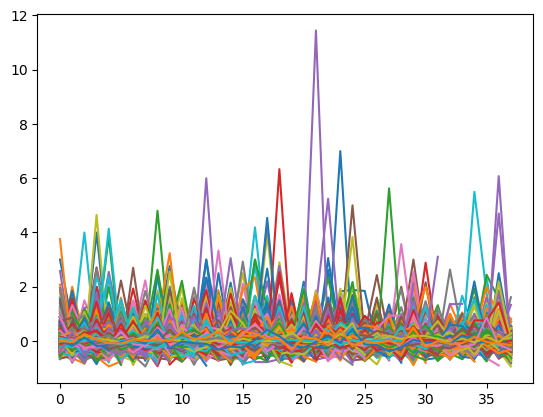

In [125]:
for name, group in y_tst.groupby(level = 0):
    plt.plot(y_tst[y_tst.index.get_level_values(level = "permno") == name].values)

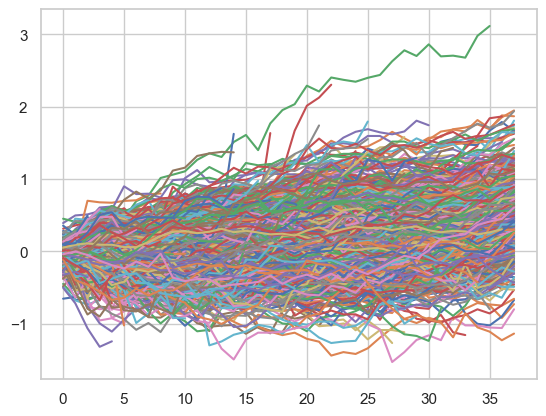

In [301]:
for name, group in y_tst.groupby(level = 0):
    plt.plot(np.cumsum(y_tst[y_tst.index.get_level_values(level = "permno") == name].values))

In [297]:
testing.index.get_level_values(level = "permno").unique()

Index([10001, 10002, 10003, 10009, 10010, 10011, 10012, 10016, 10018, 10019,
       ...
       92903, 92930, 92997, 93009, 93025, 93060, 93105, 93113, 93236, 93316],
      dtype='int64', name='permno', length=11272)

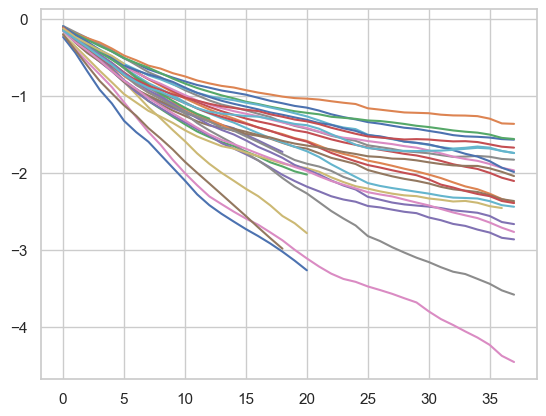

In [357]:
for i in testing.index.get_level_values(level = "permno").unique()[:30]:
    obje = pd.DataFrame((np.log(testing + 1)).groupby(level = 0)['OLS + H'].cumsum())
    obje = obje[obje.index.get_level_values(level = "permno") == i]
    plt.plot(obje.values)

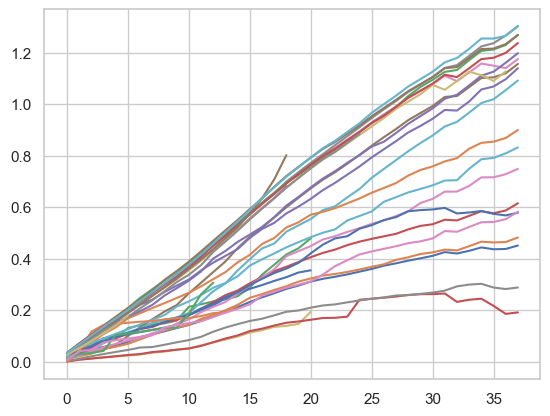

In [359]:
for i in testing.index.get_level_values(level = "permno").unique()[:30]:
    obje = pd.DataFrame((np.log(testing + 1)).groupby(level = 0)['RF'].cumsum())
    obje = obje[obje.index.get_level_values(level = "permno") == i]
    plt.plot(obje.values)

In [303]:
model_returns_top = pd.DataFrame()
model_returns_bottom = pd.DataFrame()
colonki = ["OLS + H", "OLS3", "PLS", "PCR", "ENet", "GLM", "RF", "GBRT", "NN1", "NN2", "NN3", "NN4", "NN5"]
dates = testing.groupby(level = 1).sum().index
#for i in colonki:
#    grouped_thing = testing
#    model_returns[i] = (testing['weights'] * testing[i]).groupby(level = 1).sum()

In [309]:
def top_10_percent(group):
    # Calculate the number of observations for top 10%
    top_10_percent_count = int(len(group) * 0.1)
    # Sort the group by 'value_column' in descending order
    group_sorted = group.sort_values(ascending=False)
    # Select the top 10% of observations
    top_10_percent_group = group_sorted.head(top_10_percent_count)
    return top_10_percent_group

def bottom_10_percent(group):
    # Calculate the number of observations for top 10%
    top_10_percent_count = int(len(group) * 0.1)
    # Sort the group by 'value_column' in descending order
    group_sorted = group.sort_values(ascending=True)
    # Select the top 10% of observations
    top_10_percent_group = group_sorted.head(top_10_percent_count)
    return top_10_percent_group

for i in colonki:
    model_returns_top[i] = (testing['weights'] * testing[i]).groupby(level = "date").apply(top_10_percent).groupby(level = 0).sum().values   
for i in colonki:
    model_returns_bottom[i] = (testing['weights'] * testing[i]).groupby(level = 1).apply(bottom_10_percent).groupby(level = 0).sum().values * (-1)
    
model_returns_top =  (1 + model_returns_top).cumprod(axis = 0)
model_returns_bottom =  (1 + model_returns_bottom).cumprod(axis = 0)

model_returns_top.set_index(dates, inplace=True)
model_returns_bottom.set_index(dates, inplace=True)

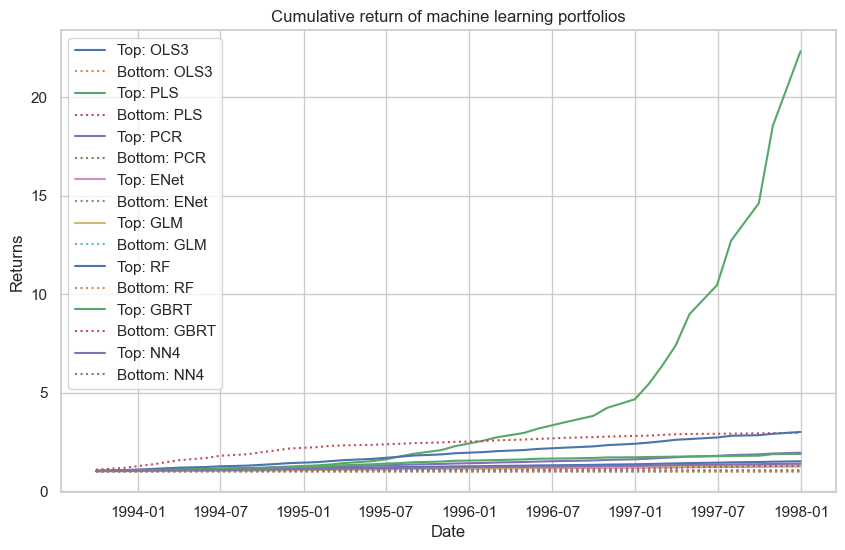

In [310]:
plotting = ["OLS3", "PLS", "PCR", "ENet", "GLM", "RF", "GBRT","NN4"]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# Plot lines from df1
for column in plotting:
    sns.lineplot(data=model_returns_top, x=model_returns_top.index, y=column, label=f'Top: {column}')
    sns.lineplot(data=model_returns_bottom, x=model_returns_bottom.index, y=column, linestyle='dotted', label=f'Bottom: {column}')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Cumulative return of machine learning portfolios')
plt.legend()
plt.show()

### Using log-returns

In [131]:
for i in colonki:
    log_return = np.log(1 + testing[i])
    model_returns_top[i] = (testing['weights'] * log_return).groupby(level = "date").apply(top_10_percent).groupby(level = 0).sum().values   
for i in colonki:
    log_return = np.log(1 + testing[i])
    model_returns_bottom[i] = (testing['weights'] * log_return).groupby(level = 1).apply(bottom_10_percent).groupby(level = 0).sum().values * (-1)
    
model_returns_top =  model_returns_top.cumsum(axis = 0)
model_returns_bottom =  model_returns_bottom.cumsum(axis = 0)

model_returns_top.set_index(dates, inplace=True)
model_returns_bottom.set_index(dates, inplace=True)

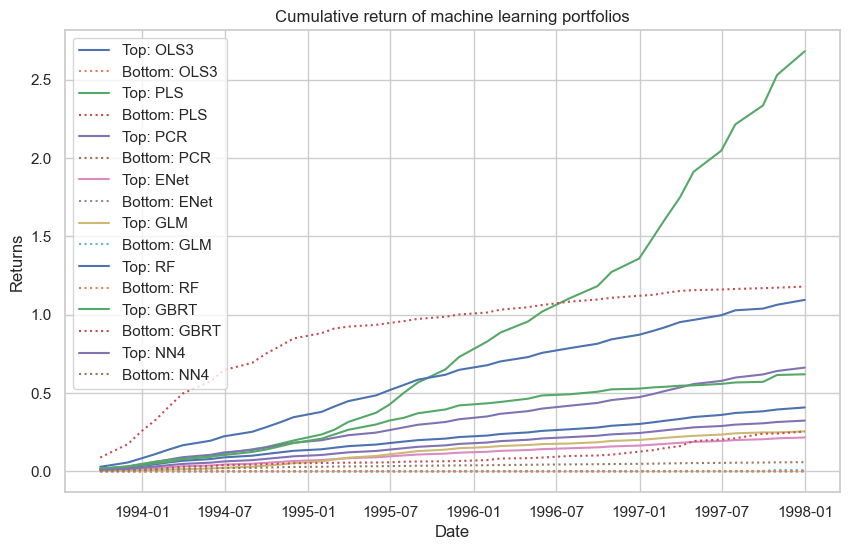

In [132]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# Plot lines from df1
for column in plotting:
    sns.lineplot(data=model_returns_top, x=model_returns_top.index, y=column, label=f'Top: {column}')
    sns.lineplot(data=model_returns_bottom, x=model_returns_bottom.index, y=column, linestyle='dotted', label=f'Bottom: {column}')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Cumulative return of machine learning portfolios')
plt.legend()
plt.show()

# 3. Replication data figures and tables

Here we clear all the datasets and figures, collect the remaining data. Starting with the extraction of the coefficients for the neural network models

## 3.1. Diebold-Moriano tests (Table 3)

*means that the value is significant on the 95% Confidence interval

In [135]:
new_moriano

,OLS-3 + H,PLS,PCR,Enet + H,GLM + H,RF,GBRT + H,NN1,NN2,NN3,NN4,NN5
OLS + H,0.8427,-0.0199,0.8976,0.9305,0.9645,0.7410,1.5751,-3.3453*,-0.1567,-1.2465,0.8727,0.0631
OLS-3 + H,0.0000,-0.8133,1.3017,0.7282,0.6261,0.2179,2.2741*,-2.2842*,-0.9409,-1.5208,0.801,-0.5137
PLS,0.0000,0.0000,0.8555,0.8646,0.8865,0.7849,1.7032,-2.4541*,-0.0289,-1.0559,0.8413,0.1318
PCR,0.0000,0.0000,0.0000,0.0745,0.1843,0.0509,2.1276*,-2.3142*,-1.0031,-1.5509,-0.2476,-0.5428
Enet + H,0.0000,0.0000,0.0000,0.0000,0.2627,0.0339,2.0707*,-2.3509*,-1.0512,-1.5673,-0.2064,-0.544
GLM + H,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,2.0269*,-2.3799*,-1.0931,-1.5806,-0.2695,-0.5541
RF,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.1685*,-2.1027*,-0.8008,-1.4441,-0.0859,-0.5415
GBRT + H,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,-2.5704*,-1.6583,-1.8413,-2.2068*,-1.1719
NN1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,3.1496*,0.8903,2.2898*,2.0749*
NN2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,-1.2841,0.9764,0.0829


In [136]:
new_moriano.to_excel("dieboldmariano_test_upd.xlsx")

## 3.2. Coefficient Significance (Figure 5 and Table 4)

The initial idea is just to print the weights for each model on one training sample. In the paper it is explicitly stated that the importance of the variables is visulized throught the ranking of variables on several training iterations.

In [138]:
significo = significo.astype("float")

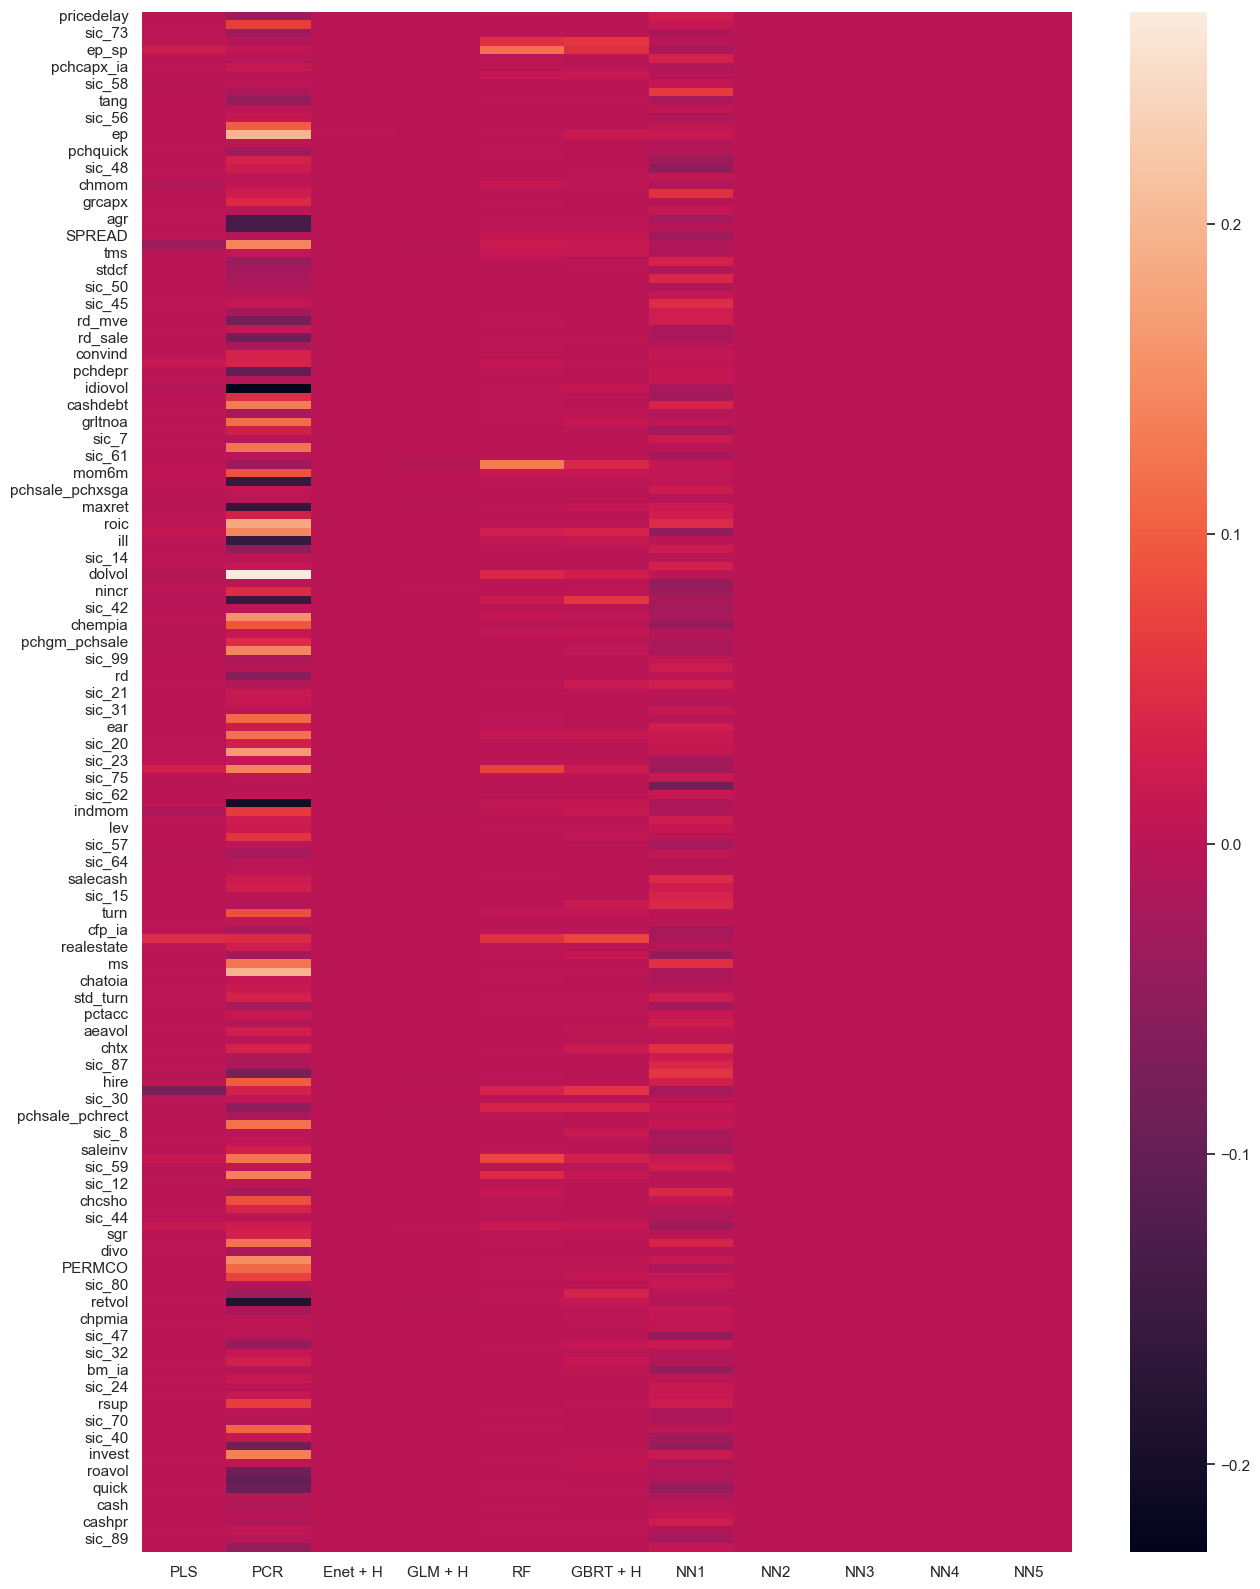

In [139]:
plt.figure(figsize=(15,20))
sns.heatmap(significo)
None

In [140]:
significo.loc[macro_colnames].to_excel("model_significance_macro.xlsx")

In [141]:
significo.to_excel("model_significance.xlsx")

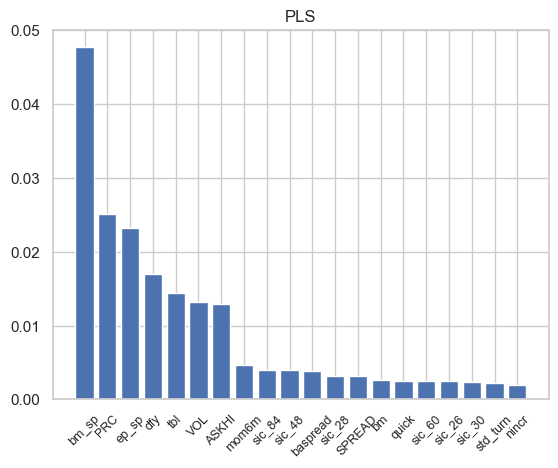

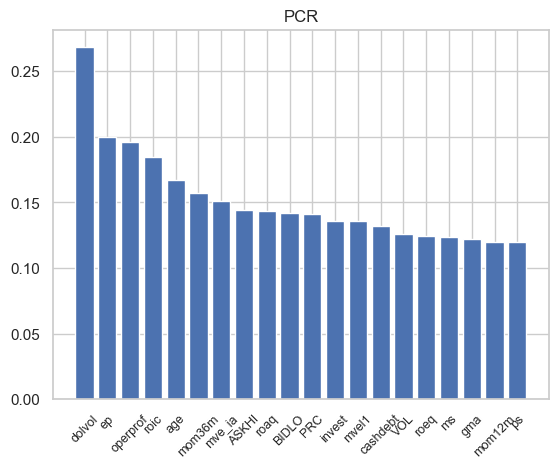

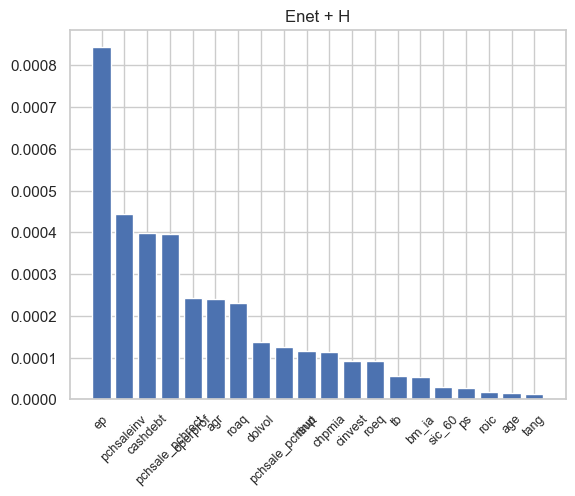

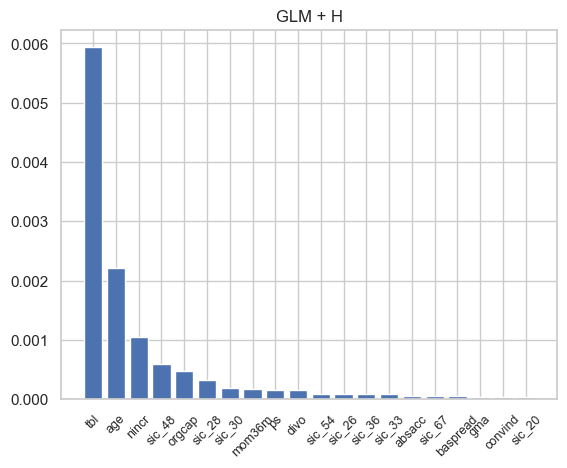

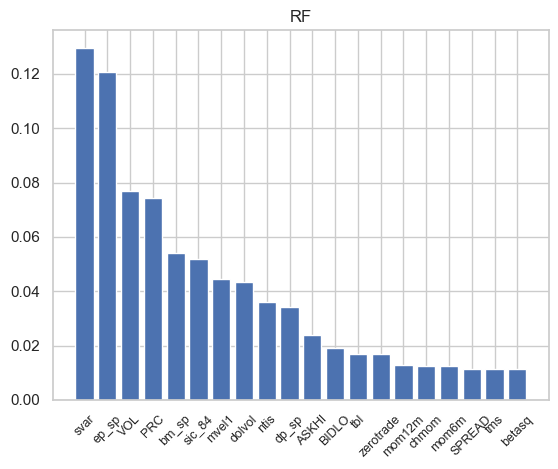

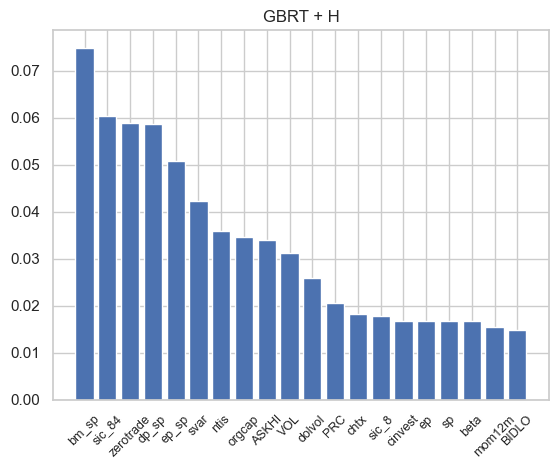

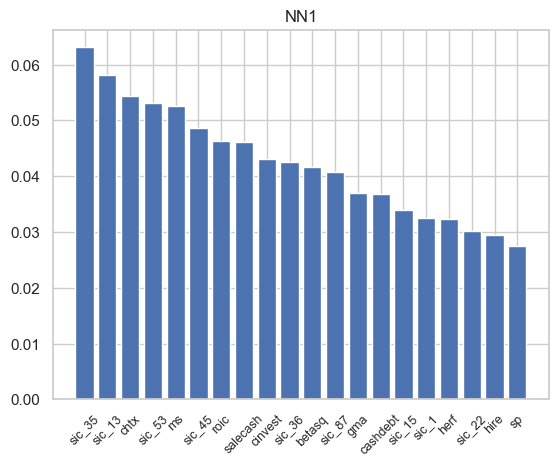

In [142]:
for i in significo.columns[:-4]:
    top = significo[i].sort_values(ascending = False)[:20]
    plt.figure()
    plt.xticks(fontsize=9, rotation=45)
    plt.title(i)
    plt.bar(x = top.index, height = top.values)
    plt.savefig(f'graphs/signif_{i}')

## 3.3. Out-of-sample performance (Table 1)

### 3.3.1. Top

We estimate out-of sample performance of the models using only top 1000 stocks in terms of market cap.

In [145]:
dta_new = data_new.reset_index()
data_new_top = dta_new.sort_values('mvel1',ascending=False).groupby('date').head(1000).reset_index().set_index(['permno', 'date'])
index_co = data_new_top.index

features = list(set(data_new_top.columns).difference({'permno','date','RET', 'index'}))
X_old = MinMaxScaler((-1,1)).fit_transform(data_new_top[features])
X_old = pd.DataFrame(X_old, columns=features, index=index_co)
y_old = data_new_top['RET']

X_trn = X_old[X_old.index.get_level_values(level = "date") <= stdt_vld]
y_trn = y_old[y_old.index.get_level_values(level = "date") <= stdt_vld]

X_vld = X_old[(X_old.index.get_level_values(level = "date") >= stdt_vld) & (X_old.index.get_level_values(level = "date") <= stdt_tst)]
y_vld = y_old[(y_old.index.get_level_values(level = "date") >= stdt_vld) & (y_old.index.get_level_values(level = "date") <= stdt_tst)]

X_tst = X_old[X_old.index.get_level_values(level = "date") >= stdt_tst]
y_tst = y_old[y_old.index.get_level_values(level = "date") >= stdt_tst]

In [146]:
epsilon = np.max(((y_trn-OLS.predict(X_trn)).quantile(.999),1))
OLS_H = HuberRegressor(epsilon=epsilon).fit(X_trn,y_trn)

params = {'n_components': [1, 5, 10, 50]}
PLS = val_fun(PLSRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

params = {'n_PCs':[1,3,5,7,10,50],'loss':['mse','huber']}
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

EN_my_mse_rdm = ENet(lmd=.01,rho=.5,loss='huber').fit(X_trn,y_trn)

params = {
    'knots':[3],
    'lmd':[1e-4,1e-1],#list(np.linspace(1e-4,1e-1,10)),
    'l1_reg':[1e-4,0]
}
GLM = val_fun(GLMRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

features_3 = ['mvel1','bm','mom1m','mom6m','mom12m','mom36m']
OLS_3 = LinearRegression().fit(X_trn[features_3],y_trn)

Model with params: {'n_components': 1} finished.
with out-of-sample R squared on validation set: 1.57685%
************************************************************
Model with params: {'n_components': 5} finished.
with out-of-sample R squared on validation set: 0.55692%
************************************************************
Model with params: {'n_components': 10} finished.
with out-of-sample R squared on validation set: 1.36790%
************************************************************
Model with params: {'n_components': 50} finished.
with out-of-sample R squared on validation set: 2.01037%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'n_components': 50}
with R2oos 2.01% on validation set.
############################################################
Model with params: {'loss': 'mse', 'n_PCs': 1} finished.
with out-of-sample R squared on validation se

In [147]:
output.iloc[1,0] =r2_score(y_tst, OLS_H.predict(X_tst))
output.iloc[1,2] = r2_score(y_tst, PCR.predict(X_tst))
output.iloc[1,3] = r2_score(y_tst, PLS.predict(X_tst))
output.iloc[1,4] = r2_score(y_tst, EN_my_mse_rdm.predict(X_tst))
output.iloc[1,5] = r2_score(y_tst, GLM.predict(X_tst))

output.iloc[1,1] = r2_score(y_tst, OLS_3.predict(X_tst[features_3]))

In [148]:
params = {
    'n_estimators': [300],
    'max_depth': [3, 6],
    'max_features': [30, 50, 100],
    'random_state': [12308]
}
RF = val_fun(RandomForestRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'max_depth': 3, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 4.60536%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 50, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 4.69362%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 100, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 4.85056%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 4.93869%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 50, 'n_estimators': 300, 'random_st

In [149]:
params = {
    'objective':[None, huber_obj],
    'max_depth':[1,2],
    'n_estimators':[500, 800, 1000],
    'random_state':[12308],
    'learning_rate':[.01,.1]
}
LGBM = val_fun(XGBRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 5.06614%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': <function huber_obj at 0x0000022AF94FC900>, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: -0.03299%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 4.73735%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'objective': <function huber_obj at 0x0000022AF94FC900>, 'random_state': 12308} finished.
with out-of-sample R squared on validatio

In [150]:
output.iloc[1,6] = r2_score(y_tst, RF.predict(X_tst))
output.iloc[1,7] = r2_score(y_tst, LGBM.predict(X_tst))

In [151]:
%%time
# NN1-Regression-[32(relu)-1(linear)]

params = {
    'n_layers': [1],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf'],
}
NN1 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN2-Regression-[32(relu)-16(relu)-1(linear)]
params = {
    'n_layers': [2],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN2 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN3-Regression-[32(relu)-16(relu)-8(relu)-1(linear)]
params = {
    'n_layers': [3],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN3 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN4-Regression-[32(relu)-16(relu)-8(relu)-4(relu)-1(linear)]
params = {
    'n_layers': [4],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN4 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN5-Regression-[32(relu)-16(relu)-8(relu)-4(relu)-2(relu)-1(linear)]
params = {
    'n_layers': [5],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN5 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 720, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.00590%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 720, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 1.98336%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 720, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.05055%


UsageError: Line magic function `%%time` not found.


In [152]:
output.iloc[1,8] = r2_score(y_tst, NN1.predict(X_tst))
output.iloc[1,9] = r2_score(y_tst, NN2.predict(X_tst))
output.iloc[1,10] = r2_score(y_tst, NN3.predict(X_tst))
output.iloc[1,11] = r2_score(y_tst, NN4.predict(X_tst))
output.iloc[1,12] = r2_score(y_tst, NN5.predict(X_tst))

### 3.3.2. Bottom

We estimate out-of sample performance of the models using only bottom 1000 stocks in terms of market cap. (Table 1)

In [154]:
data_new_bottom = dta_new.sort_values('mvel1',ascending=False).groupby('date').tail(1000).reset_index().set_index(['permno', 'date'])
index_co = data_new_bottom.index

features = list(set(data_new_bottom.columns).difference({'permno','date','RET', 'index'}))
X_old = MinMaxScaler((-1,1)).fit_transform(data_new_top[features])
X_old = pd.DataFrame(X_old, columns=features, index=index_co)
y_old = data_new_top['RET']

X_trn = X_old[X_old.index.get_level_values(level = "date") <= stdt_vld]
y_trn = y_old[y_old.index.get_level_values(level = "date") <= stdt_vld]

X_vld = X_old[(X_old.index.get_level_values(level = "date") >= stdt_vld) & (X_old.index.get_level_values(level = "date") <= stdt_tst)]
y_vld = y_old[(y_old.index.get_level_values(level = "date") >= stdt_vld) & (y_old.index.get_level_values(level = "date") <= stdt_tst)]

X_tst = X_old[X_old.index.get_level_values(level = "date") >= stdt_tst]
y_tst = y_old[y_old.index.get_level_values(level = "date") >= stdt_tst]

In [155]:
epsilon = np.max(((y_trn-OLS.predict(X_trn)).quantile(.999),1))
OLS_H = HuberRegressor(epsilon=epsilon).fit(X_trn,y_trn)

params = {'n_components': [1, 5, 10, 50]}
PLS = val_fun(PLSRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

params = {'n_PCs':[1,3,5,7,10,50],'loss':['mse','huber']}
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

EN_my_mse_rdm = ENet(lmd=.01,rho=.5,loss='huber').fit(X_trn,y_trn)

params = {
    'knots':[3],
    'lmd':[1e-4,1e-1],#list(np.linspace(1e-4,1e-1,10)),
    'l1_reg':[1e-4,0]
}
GLM = val_fun(GLMRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

features_3 = ['mvel1','bm','mom1m','mom6m','mom12m','mom36m']
OLS_3 = LinearRegression().fit(X_trn[features_3],y_trn)

Model with params: {'n_components': 1} finished.
with out-of-sample R squared on validation set: 2.90212%
************************************************************
Model with params: {'n_components': 5} finished.
with out-of-sample R squared on validation set: 2.60085%
************************************************************
Model with params: {'n_components': 10} finished.
with out-of-sample R squared on validation set: 2.53237%
************************************************************
Model with params: {'n_components': 50} finished.
with out-of-sample R squared on validation set: 2.51421%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'n_components': 1}
with R2oos 2.90% on validation set.
############################################################
Model with params: {'loss': 'mse', 'n_PCs': 1} finished.
with out-of-sample R squared on validation set

In [156]:
output.iloc[2,0] =r2_score(y_tst, OLS_H.predict(X_tst))
output.iloc[2,2] = r2_score(y_tst, PCR.predict(X_tst))
output.iloc[2,3] = r2_score(y_tst, PLS.predict(X_tst))
output.iloc[2,4] = r2_score(y_tst, EN_my_mse_rdm.predict(X_tst))
output.iloc[2,5] = r2_score(y_tst, GLM.predict(X_tst))

output.iloc[2,1] = r2_score(y_tst, OLS_3.predict(X_tst[features_3]))

In [157]:
params = {
    'n_estimators': [300],
    'max_depth': [3, 6],
    'max_features': [30, 50, 100],
    'random_state': [12308]
}
RF = val_fun(RandomForestRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'max_depth': 3, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.92895%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 50, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.81395%
************************************************************
Model with params: {'max_depth': 3, 'max_features': 100, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.61992%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 30, 'n_estimators': 300, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 2.78246%
************************************************************
Model with params: {'max_depth': 6, 'max_features': 50, 'n_estimators': 300, 'random_st

In [158]:
params = {
    'objective':[None, huber_obj],
    'max_depth':[1,2],
    'n_estimators':[500, 800, 1000],
    'random_state':[12308],
    'learning_rate':[.01,.1]
}
LGBM = val_fun(XGBRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 3.15815%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500, 'objective': <function huber_obj at 0x0000022AF94FC900>, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: -0.03299%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'objective': None, 'random_state': 12308} finished.
with out-of-sample R squared on validation set: 3.16400%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 800, 'objective': <function huber_obj at 0x0000022AF94FC900>, 'random_state': 12308} finished.
with out-of-sample R squared on validatio

In [159]:
output.iloc[2,6] = r2_score(y_tst, RF.predict(X_tst))
output.iloc[2,7] = r2_score(y_tst, LGBM.predict(X_tst))

In [160]:
%%time
# NN1-Regression-[32(relu)-1(linear)]

params = {
    'n_layers': [1],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf'],
}
NN1 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN2-Regression-[32(relu)-16(relu)-1(linear)]
params = {
    'n_layers': [2],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN2 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN3-Regression-[32(relu)-16(relu)-8(relu)-1(linear)]
params = {
    'n_layers': [3],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN3 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN4-Regression-[32(relu)-16(relu)-8(relu)-4(relu)-1(linear)]
params = {
    'n_layers': [4],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN4 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

%%time
# NN5-Regression-[32(relu)-16(relu)-8(relu)-4(relu)-2(relu)-1(linear)]
params = {
    'n_layers': [5],
    'loss': ['mse'],
    'l1': [1e-5,1e-3],
    'learning_rate': [.001,.01],
    'batch_size': [int(X_trn.shape[0]/50)],
    'epochs': [100],
    'random_state': [12308],
    'BatchNormalization': [True],
    'patience':[5],
    'verbose': [0],
    'monitor':['val_loss','val_R_oos_tf']
}
NN5 = val_fun(NN,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,is_NN=True,sleep=5)

Model with params: {'BatchNormalization': True, 'batch_size': 720, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: -0.90717%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 720, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.001, 'loss': 'mse', 'monitor': 'val_R_oos_tf', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.01957%
************************************************************
Model with params: {'BatchNormalization': True, 'batch_size': 720, 'epochs': 100, 'l1': 1e-05, 'learning_rate': 0.01, 'loss': 'mse', 'monitor': 'val_loss', 'n_layers': 1, 'patience': 5, 'random_state': 12308, 'verbose': 0} finished.
with out-of-sample R squared on validation set: 0.56499%
*

UsageError: Line magic function `%%time` not found.


In [161]:
output.iloc[2,8] = r2_score(y_tst, NN1.predict(X_tst))
output.iloc[2,9] = r2_score(y_tst, NN2.predict(X_tst))
output.iloc[2,10] = r2_score(y_tst, NN3.predict(X_tst))
output.iloc[2,11] = r2_score(y_tst, NN4.predict(X_tst))
output.iloc[2,12] = r2_score(y_tst, NN5.predict(X_tst))

In [162]:
output.to_excel("reality_here.xlsx")

In [163]:
output

,OLS + H,OLS-3 + H,PCR,PLS,Enet + H,GLM + H,RF,GBRT + H,NN1,NN2,NN3,NN4,NN5
All,-0.199101,-0.011605,-0.001258,-0.202375,-0.000450,0.002020,0.002035,0.194713,-1.150690,-0.208271,-0.730981,-0.003271,-0.181129
Top 1000,-0.800092,-0.009566,-0.002754,-0.804972,0.001141,0.012862,-0.026477,0.324129,-0.443431,-4.094151,-4.561101,-0.160826,-2.154012
Bottom 1000,-0.006434,-0.121941,-0.040279,-0.094366,-0.000100,-0.002379,-0.002627,-0.002309,-0.013112,-3.979236,-2.817272,-0.191466,-2.605137
